# _Shewanella_ Cyclic di-GMP metabolism

## Pangenome analysis

### Author: Shawn Higdon

#### Date: November 19, 2021

> Here we visualize results from pangenome analysis carried out by Kaisa Thorell using `Roary` with a `90%` identity threshold setting for clustering of homologous protein coding gene sequences.

#### Overview

* [A] Link to pangenome files
* [B] Plot the pangenome accessory gene binmap with clustered dendrogram
* [C] Plot the pangenome rarefaction figure
* [D] Plot other pangenome figures

# __[A]__: Pangenome Files

> Create symbolic link to _K. Thorell_ pangenome output folder

In [1]:
%%bash

ln -fs ../../../S_algae_2020/roary_dec2020/roary_KIonly_id90/ . && ls roary_KIonly_id90

accessory_binary_genes.fa
accessory_binary_genes.fa.newick
accessory_graph.dot
accessory.header.embl
accessory.tab
blast_identity_frequency.Rtab
clustered_proteins
core_accessory_graph.dot
core_accessory.header.embl
core_accessory.tab
core_alignment_header.embl
core_gene_alignment.aln
gene_presence_absence.csv
gene_presence_absence.Rtab
number_of_conserved_genes.Rtab
number_of_genes_in_pan_genome.Rtab
number_of_new_genes.Rtab
number_of_unique_genes.Rtab
pan_genome_reference.fa
summary_statistics.txt


> Switch to IR Kernel

In [1]:
# Load packages
suppressPackageStartupMessages(library(pagoo))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(ggtree))
suppressPackageStartupMessages(library(phangorn))
suppressPackageStartupMessages(library(magrittr))
suppressPackageStartupMessages(library(ggnewscale))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(plotrix))
suppressPackageStartupMessages(library(ggplotify))

Warning message:
“package ‘plotrix’ was built under R version 4.1.1”
Warning message:
“package ‘ggplotify’ was built under R version 4.1.1”


> __Read in Roary Output__

In [2]:
# read in gene presence absence file from roary
gpa_csv <- "roary_KIonly_id90/gene_presence_absence.csv"

# create pagoo pangenome object
pg <- roary_2_pagoo(gene_presence_absence_csv = gpa_csv)

# inspect pangenome summary
pg$summary_stats

Reading csv file (roary).

Processing csv file.

Loading PgR6M class object.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Checking provided cluster metadata.

Creating panmatrix.

Populating class.

Done.



DataFrame with 4 rows and 2 columns
     Category    Number
  <character> <integer>
1       Total     10122
2        Core      3811
3       Shell      2891
4       Cloud      3420

> __Add Isolate Metadata__

,org,gen_size_Mb,p_GC,source,Label,src_color
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,CECT5071,4.92,53.1,Alga,CECT5071,#B15928
2,G1,4.89,53.0,Human,G1,#E31A1C
3,A291,4.97,53.0,Fish,A291,#1B9E77
4,A59,4.82,53.1,Bird,A59,#386CB0
5,150735,5.07,52.8,Human,150735,#E31A1C
6,SF7,4.84,53.0,Human,SF7,#E31A1C


DataFrame with 4 rows and 2 columns
     Category    Number
  <character> <integer>
1       Total     10122
2        Core      3811
3       Shell      2891
4       Cloud      3420

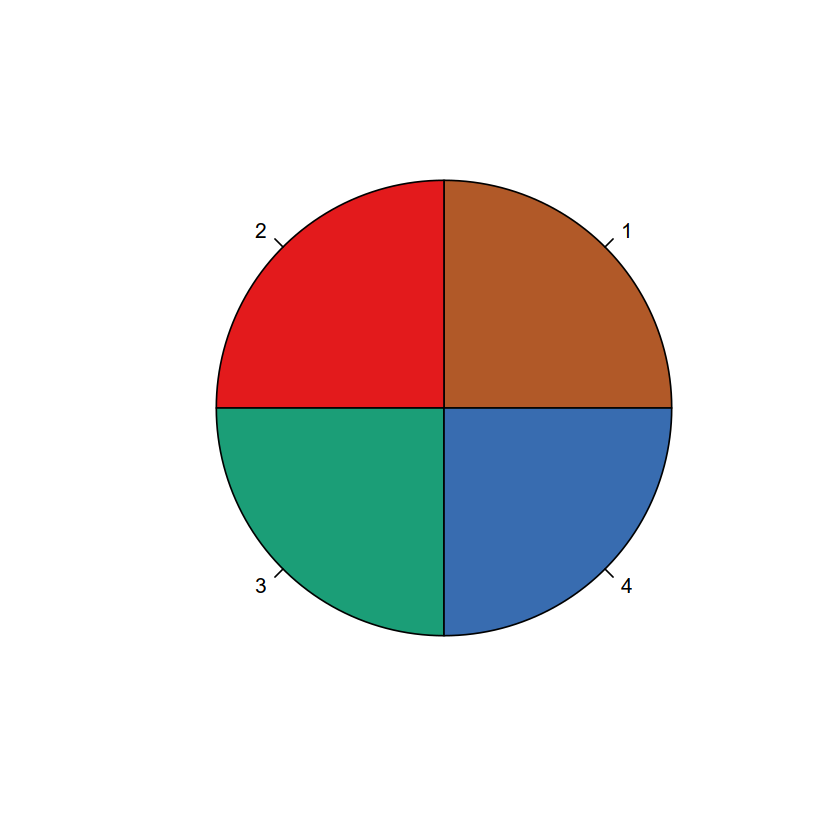

In [3]:
# read_csv
pg_meta <- read_csv("./strain_metadata.csv", col_names = T, col_types = "cddc")
#pg_meta <- pg_meta %>% mutate(across(everything(), as.character))
pg_meta <- as.data.frame(pg_meta)
pg_meta$Label <- pg_meta$org

# create unique color for each isolation source (patient ID or GENBANK)
n_colors <- length(unique(pg_meta$source))

palette_info <- brewer.pal.info[brewer.pal.info$category == "qual", ]  # Extract color info
palette_all <- unlist(mapply(brewer.pal,                     # Create vector with all colors
                              palette_info$maxcolors,
                              rownames(palette_info)))

set.seed(1234)                                             # Set random seed
src_colors <- sample(palette_all, n_colors)                    # Sample colors

pie(rep(1, n_colors),                                         # Draw colors in pie chart
    col = src_colors)

src_color_df <- data.frame(src=unique(pg_meta$source),
                           src_color= src_colors)



# add to lc_cmp_meta2
pg_meta$src_color <- src_color_df$src_color[match(pg_meta$source, src_color_df$src)]

# preview
head(stat(pg_meta))

# add metadata to pangenome object
pg$add_metadata(map = "org", pg_meta)

# inspect pangenome summary
pg$summary_stats

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
“In prcomp.default(self$pan_matrix, center = center, scale. = scale., 
    ...) :
 extra argument ‘size’ will be disregarded”


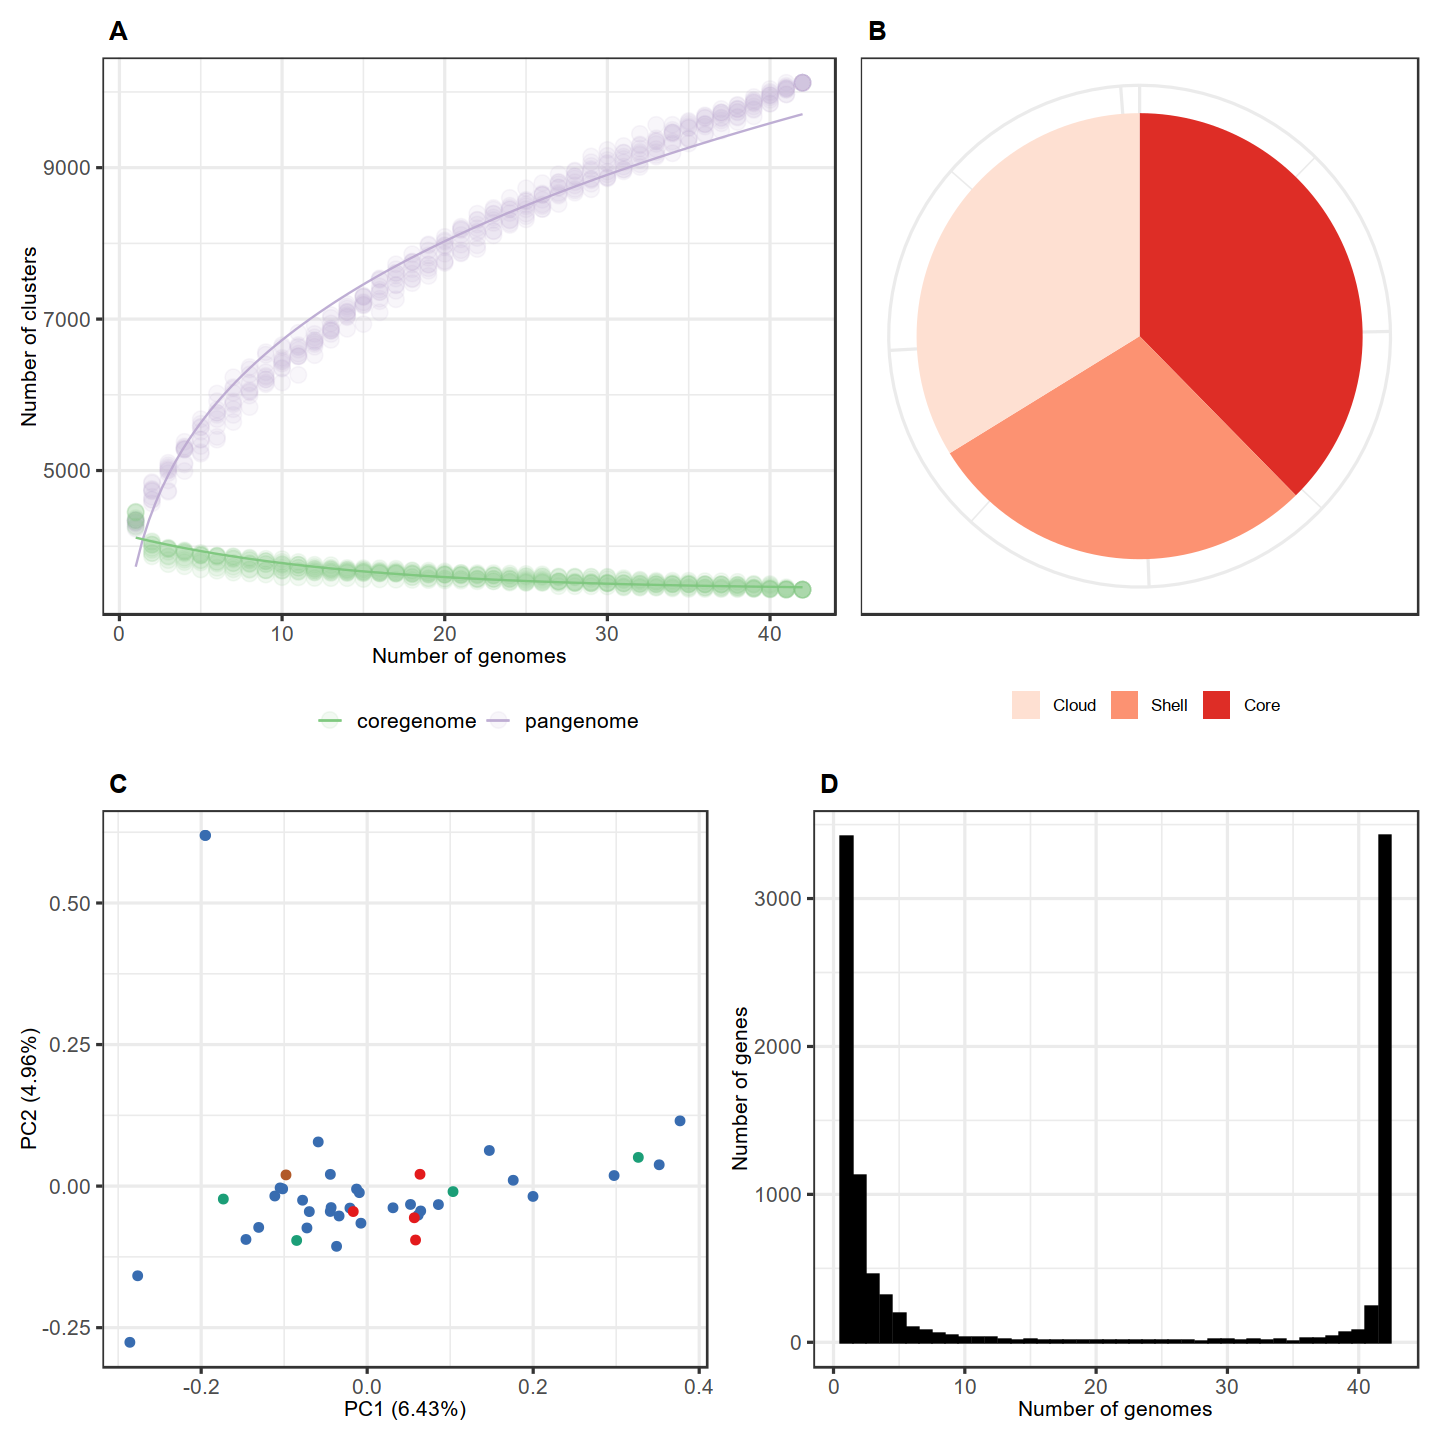

In [4]:
## set plot params
options(repr.plot.height=12, repr.plot.width = 12)

# 1. Pangenome curves
curves <- pg$gg_curves() +                                     # Plot core- and pan-genome curves
          scale_color_brewer(palette = "Accent") +
          #scale_color_manual(values = c('black', 'black')) +  # Customize line colors
          geom_point(alpha = .1, size = 4) + #, color = 'grey') + # Add semi-transparent data points
          theme_bw(base_size = 15) +                          # Customize background theme
          labs(subtitle = " A ") +
          theme(legend.position = 'bottom',                     # move legend to bottom
          legend.title = element_blank(),
          plot.subtitle = element_text(face = "bold"),
          axis.title = element_text(size = 12),                     # Customize axis title
          axis.text = element_text(size = 12))                      # Customize axis text size

# 2. Pie chart of core and accessory genes
pie <- pg$gg_pie() +                                         # Plot pie chart
  theme_bw(base_size = 15) +                                # Customize background theme
  scale_fill_discrete(guide = guide_legend(keywidth = .75,
                                           keyheight = .75)) + # Customize fill
  scale_fill_brewer(palette = "Reds") +                    # Customize fill color
  scale_x_discrete(breaks = c(0, 25, 50, 75)) +             # Customize axis scales
  labs(subtitle = " B ") +
  theme(legend.position = 'bottom',                         # Customize legend position
        legend.title = element_blank(),                     # Remove legend title
        legend.text = element_text(size = 10),              # Change legend text size
        legend.margin = margin(0, 0, 13, 0),                # Change legend margins
        legend.box.margin = margin(0, 0, 5, 0),             # Change box margins
        axis.title.x = element_blank(),                     # Remove X-axis title
        axis.title.y = element_blank(),                     # Remove Y-axis title
        axis.ticks = element_blank(),                       # Remove axis ticks
        plot.subtitle = element_text(face = "bold"),
        axis.text.x = element_blank())                      # Remove X-axis text

# 3. PCA of accessory genes colored by host
pca <- pg$gg_pca(colour = 'source', size = 2) +                # Plot PCA, color by host
  scale_color_manual(values = pg_meta$src_color, name="Isolation Source") +
  theme_bw(base_size = 15) +                                # Customize background theme
  labs(subtitle = " C ") +
  theme(legend.position = 'none') +                       # Customize legend position
  theme(axis.title = element_text(size = 12),               # Customize axis title
        plot.subtitle = element_text(face = "bold"),
        axis.text = element_text(size = 12))               # Customize axis text size


# 4. Gene frequency bar plots
bars <- pg$gg_barplot() +                                       # Plot gene frequency distribution
  theme_bw(base_size = 15) +                                   # Customize background color
  labs(subtitle = " D ") +
  theme(axis.title = element_text(size = 12),                  # Customize axis label size
        plot.subtitle = element_text(face = "bold"),
        axis.text=element_text(size = 12)) +                   # Customize axis text size
  geom_bar(stat = 'identity', color = 'black', fill = 'black') # Customize bar color and borders


# 5. Use patchwork to arrange plots using math operators
grid1 <- (curves + pie) / (pca + bars)

grid1

#### __Gene Presence / Absence__ Plot

> Use ggtree and phangorn packages to create a tree based gene presence absence binmap plot with dendrogram

> Plot only shell genome (accessory) gene clusters, ignore core genome gene clusters


In [5]:
test <- as.character(pg$shell_clusters$cluster)

test2 <- as.character(pg$cloud_clusters$cluster)

test3 <- as.character(c(pg$shell_clusters$cluster, pg$cloud_clusters$cluster))

length(test3)

[1] 6311

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



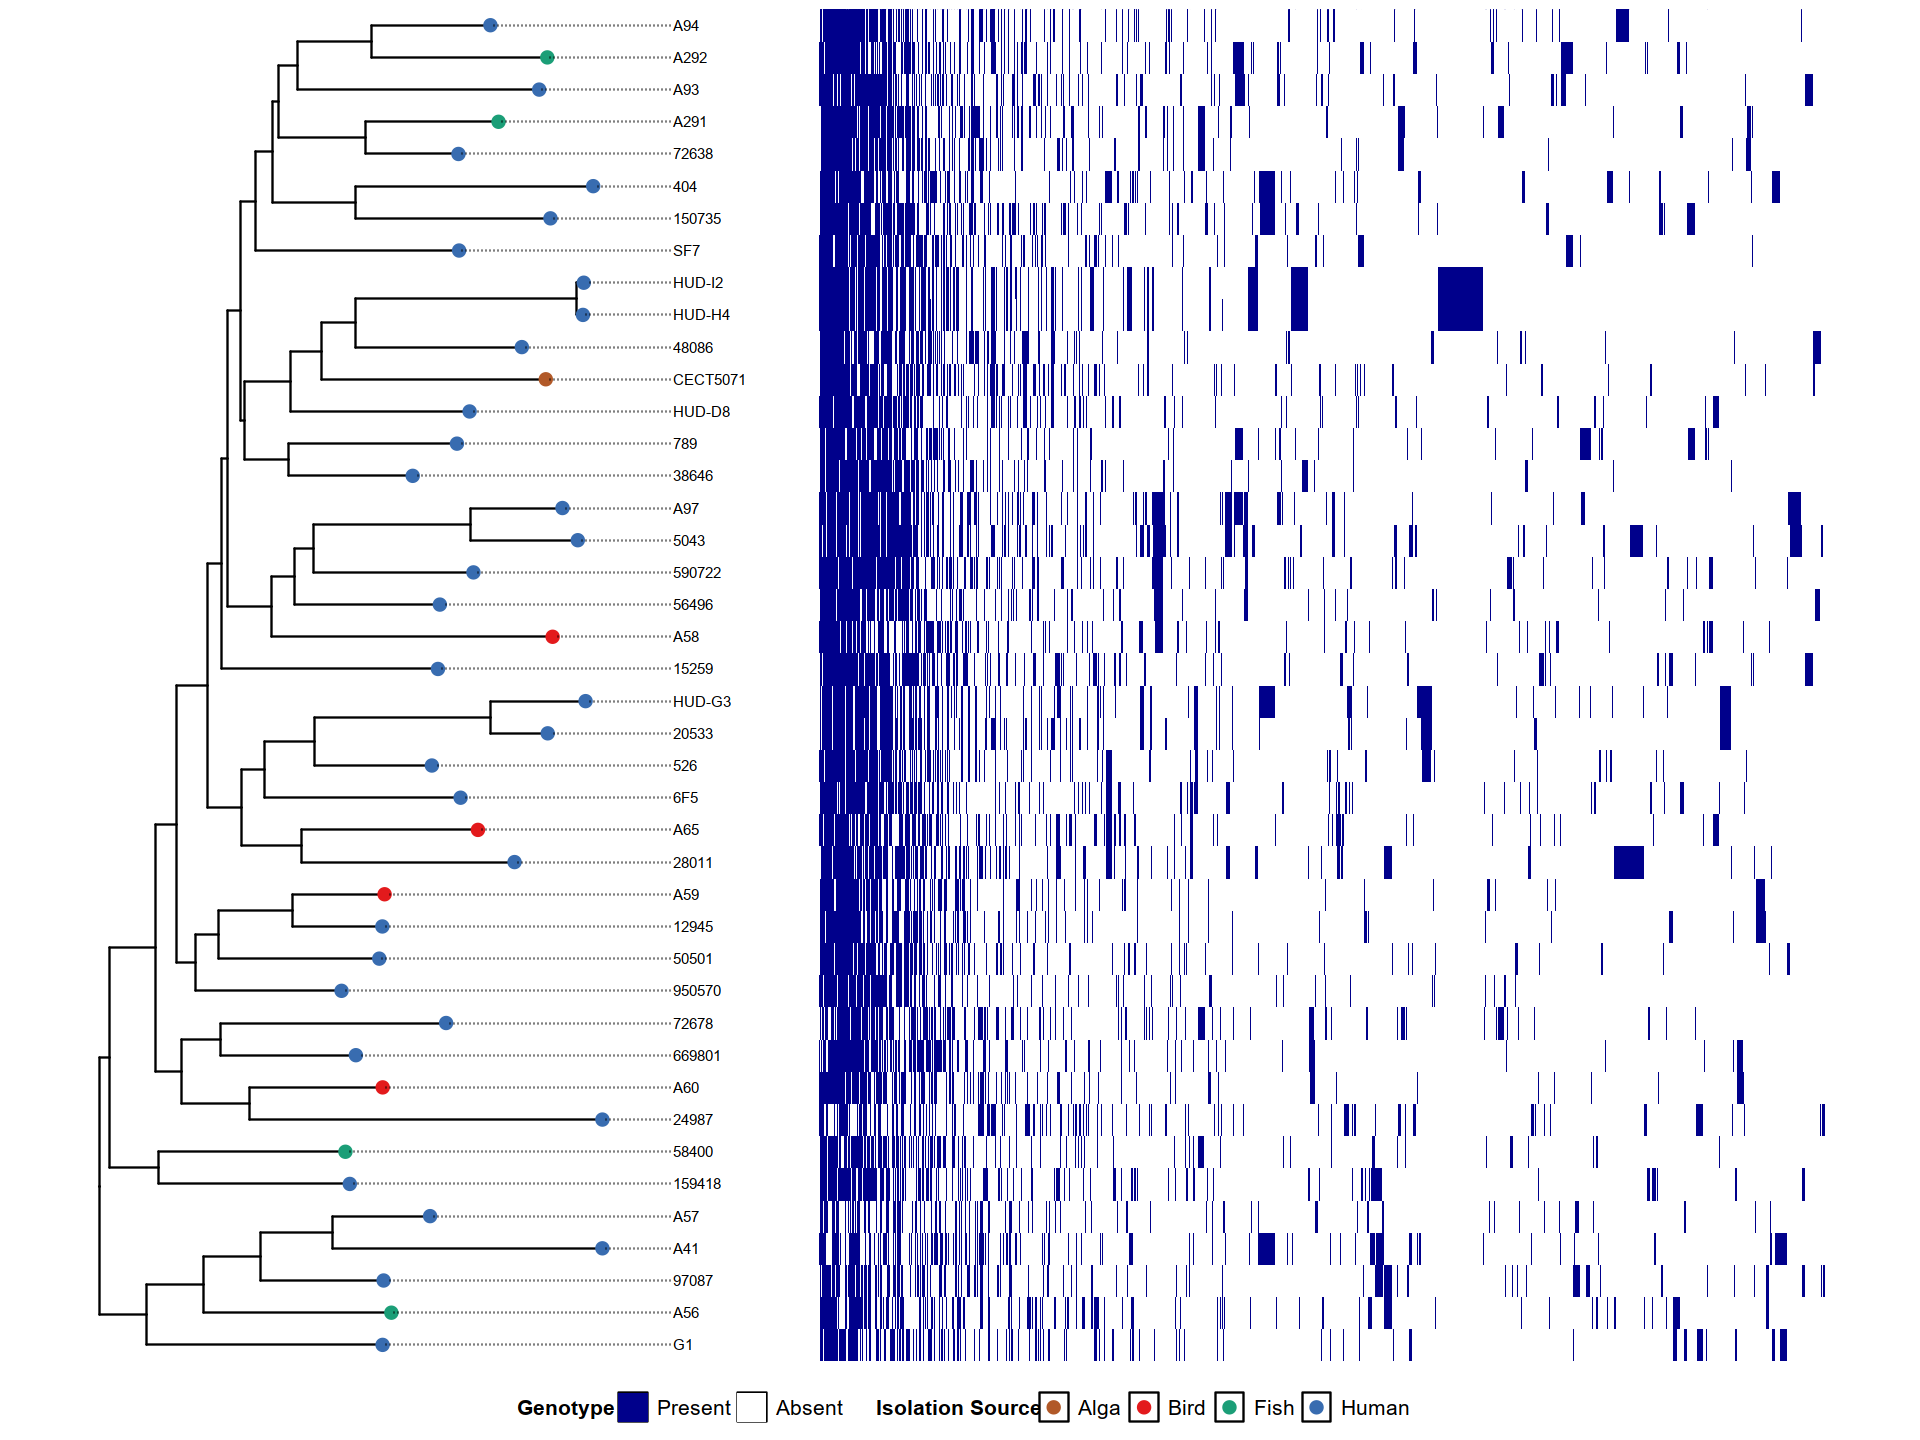

In [109]:
## set plot params
options(repr.plot.height=12, repr.plot.width = 16)

# Extract only the shell clusters from the panmatrix
pm <- pg$pan_matrix[,  as.character(pg$shell_clusters$cluster) ]

# The following is to order the columns to make the heatmap "pretty"
csm <- colSums(pm)
spl <- split(names(csm), csm)
tpm <- t(pm)
norder <- lapply(spl, function(x) {
  if (length(x)<2){
    x
  }else{
    d <- vegan::vegdist(tpm[x, , drop=F], method = "jaccard", binary = T, na.rm = T)
    hc <- hclust(d, "single")
    x[hc$order]
  }
})

norder <- norder[order(as.integer(names(norder)), decreasing = T)]
forder <- unlist(norder)
pm <- pm[, forder,  drop = F]

# Now transform matrix from integer to character
pm[which(pm >= 1 , arr.ind = TRUE)] <- "Present"
pm[which(pm == 0)] <- "Absent"

# Suppose you already have a `phylo` object:

phylo <- read.tree("./roary_KIonly_id90/accessory_binary_genes.fa.newick")

tree <- midpoint(phylo) %>%         # midpoint root
  ggtree() %<+%                     # Create ggtree
  as.data.frame(pg$organisms)        # Attach organism metadata

ggtree <- tree + geom_tippoint(aes(color = source), size = 3) + 
    scale_color_manual(values = pg_meta$src_color, name="Isolation Source") +
    geom_tiplab(aes(label = Label), size=3.0, align=TRUE, linesize=.5, offset = 0.05)

gh1 <- gheatmap(ggtree, pm, offset = 0.16, width = 2, colnames = F, color = NA) + 
    scale_fill_manual(breaks=c("Present", "Absent"), 
                        values=c("darkblue", "white"), 
                        name="Genotype") +
    theme(legend.title = element_text(size = 12, face = "bold"),
         legend.text = element_text(size = 12),
         legend.key = element_rect(fill = "white", colour = "black"),
         legend.position = "bottom")

gh1

ggsave("./r_plots/Shewanella_42_pangenome_accessory_only_clustered.pdf", gh1, device = "pdf", width = 16, height = 16, units = "in", dpi = 600)

> Patch together all 5 plots in a publication quality grid

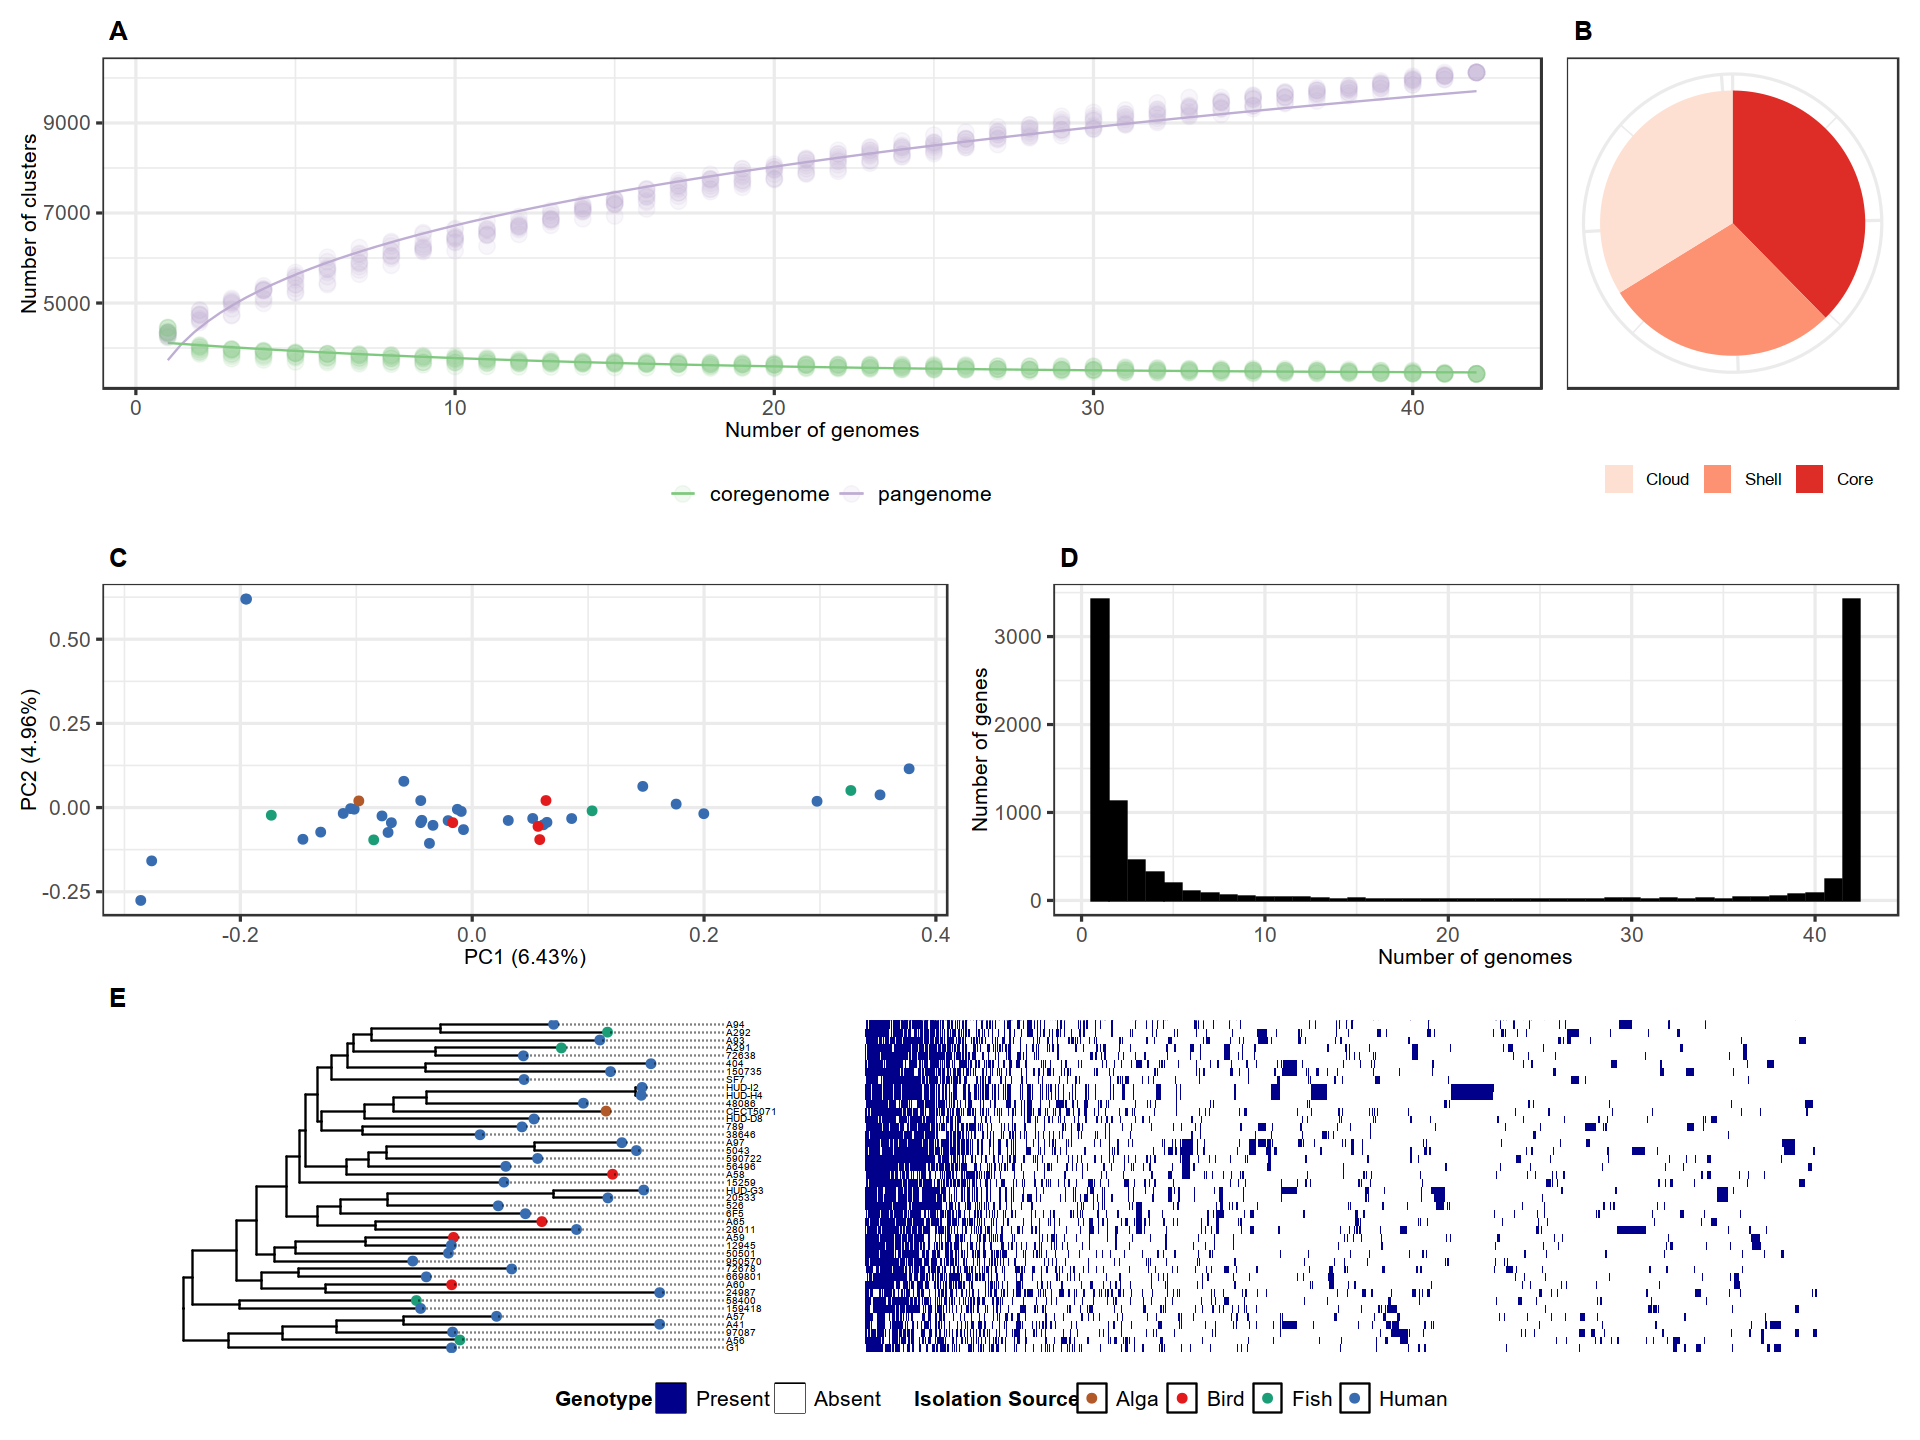

In [7]:
grid2 <- gh1 + labs(subtitle = " E ") + theme(plot.subtitle = element_text(size = 15, face = "bold"))

grid3 <- grid1 / grid2 

grid3

# save plot
ggsave("./r_plots/pangenome_stats_grid.pdf", grid3, height = 50, width = 30, units = "cm", dpi = 600 )

#### Annotate Clusters

> Steps:

1. Translate reference pangenome sequences and export to `faa`
2. Annotate with `emapper.py`

In [8]:
# read in fasta
pg_refseq <- readDNAStringSet("./roary_KIonly_id90/pan_genome_reference.fa")

# Number of sequences
length(pg_refseq)

#translate to amino acids and write to file
pg_refseq %>%
    translate(if.fuzzy.codon = "solve") %>%
    writeXStringSet(filepath = "pg_representatives.faa")

[1] 10122

Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[39]]': last 2 bases were ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[212]]': last base was ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[213]]': last base was ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[268]]': last 2 bases were ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[601]]': last base was ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[602]]': last base was ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[603]]': last base was ignored”
Warning message in .Call2("DNAStringSet_translate", x, 

> Switch to `smash-jupyter` python kernel to run `emapper.py`

In [3]:
%%bash

# make output directory
mkdir -p pg_rep_emapper_1e-6

#emapper.py -i pg_representatives.faa \
#    -o pg_rep_emapper \
#    --data_dir /ceph/db/eggnog/db_eggnog_mapper \
#    --cpu 24 \
#    --output_dir pg_rep_emapper_1e-6 \
#    --evalue 0.000001

usage: emapper.py [-h] [-v] [--list_taxa] [--cpu NUM_CPU]
                  [--mp_start_method {fork,spawn,forkserver}] [--resume]
                  [--override] [-i FASTA_FILE]
                  [--itype {CDS,proteins,genome,metagenome}] [--translate]
                  [--annotate_hits_table SEED_ORTHOLOGS_FILE] [-c FILE]
                  [--data_dir DIR] [--genepred {search,prodigal}]
                  [--trans_table TRANS_TABLE_CODE] [--training_genome FILE]
                  [--training_file FILE]
                  [--allow_overlaps {none,strand,diff_frame,all}]
                  [--overlap_tol FLOAT]
                  [-m {diamond,mmseqs,hmmer,no_search,cache}]
                  [--pident PIDENT] [--query_cover QUERY_COVER]
                  [--subject_cover SUBJECT_COVER] [--evalue EVALUE]
                  [--score SCORE] [--dmnd_algo {auto,0,1,ctg}]
                  [--dmnd_db DMND_DB_FILE]
                  [--sensmode {default,fast,mid-sensitive,sensitive,more-sensitive,ver

> Annotations of representative genes from 10,122 orthologous gene clusters produced 8,241 hits with e-values less than or equal to 1e-6 when querying with diamond via eggnog mapper.

> Next steps in BASH:

1. extract headers from `pan_genome_reference.fa` and convert to tab-separated-values file
2. Create symbolic link to kegg pathway/ko map files

Plan for annotation plot

1. Extract reference pan genome headers from fasta file to create gene_cluster_id :: reference_gene_id map file `[x]`
2. read in _**pg_ref_map.csv**_ `[x]`
3. subset the gene clusters by core, shell, cloud `[x]`
4. extract records from kegg annotation file for each subset `[x]`
5. Add variable for genome category `[x]`
6. map KEGG pathway definition to kegg id `[x]`
7. compute % of total KEGG pathway genes per pangenome category `[]`
8. join all 3 tables `[]`
9. ggplot bar plot side by side `[]`

In [ ]:
%%bash

# open map file with headers
echo "gene,cluster" > pg_ref_map.csv

# extract fasta headers from reference pangenome multi-fasta
grep "^>" roary_KIonly_id90/pan_genome_reference.fa | sed 's/^.//g' | awk '{gsub(" ",",");print}' >> pg_ref_map.csv

In [ ]:
%%bash

# create symbolic link to directory with kegg map files
ln -s ~/kegg_maps/ .

> Switch back to `smash-jupyter` IR kernel

In [9]:
# read in pangenome reference map of representative genes to cluster id
pg_ref_map <- read_csv("./pg_ref_map.csv", col_names = T)
head(pg_ref_map)


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  gene = col_character(),
  cluster = col_character()
)




gene,cluster
<chr>,<chr>
12945_00001,dnaA
12945_00002,dnaN
12945_00003,recF
12945_00004,gyrB
12945_00005,group_1835
12945_00006,glyS


##### __Subset gene clusters__

In [10]:
# core
pg_core <- as_tibble(pg$core_clusters) %>%
    left_join(., pg_ref_map, by = "cluster")
pg_core$category <- "Core"
summary(pg_core)
head(pg_core)

# shell
pg_shell <- as_tibble(pg$shell_clusters) %>%
    left_join(., pg_ref_map, by = "cluster")
pg_shell$category <- "Shell"
summary(pg_shell)
head(pg_shell)

# cloud
pg_cloud <- as_tibble(pg$cloud_clusters) %>%
    left_join(., pg_ref_map, by = "cluster")
pg_cloud$category <- "Cloud"
summary(pg_cloud)
head(pg_cloud)

   cluster           Annotation            gene             category        
 Length:3811        Length:3811        Length:3811        Length:3811       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

cluster,Annotation,gene,category
<chr>,<chr>,<chr>,<chr>
aaeA_1,hypothetical protein,12945_01081,Core
aaeA_2,Translocation and assembly module TamA,12945_03661,Core
aaeB,hypothetical protein,12945_01080,Core
aas,hypothetical protein,12945_00203,Core
aat,"Periplasmic nitrate reductase, electron transfer subunit",12945_02371,Core
abgT,Protein-glutamine gamma-glutamyltransferase,12945_00113,Core


   cluster           Annotation            gene             category        
 Length:2891        Length:2891        Length:2891        Length:2891       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

cluster,Annotation,gene,category
<chr>,<chr>,<chr>,<chr>
abgT_1,hypothetical protein,24987_03888,Shell
acoR,Ribonuclease HI,12945_03991,Shell
adhT,HTH-type transcriptional regulator ArgP,48086_01454,Shell
adrB_2,Outer membrane protein OprM,12945_02241,Shell
adrB_8,hypothetical protein,12945_03619,Shell
ais,hypothetical protein,12945_03166,Shell


   cluster           Annotation            gene             category        
 Length:3420        Length:3420        Length:3420        Length:3420       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

cluster,Annotation,gene,category
<chr>,<chr>,<chr>,<chr>
acuI_1,Uracil permease,A57_03919,Cloud
adhR,hypothetical protein,97087_00985,Cloud
adrA_4,hypothetical protein,HUD-G3_04440,Cloud
algA,hypothetical protein,150735_02974,Cloud
alkA_2,hypothetical protein,789_02858,Cloud
ant1,hypothetical protein,A41_02423,Cloud


##### __Eggnog mapper Annotations__

>  read in eggnog mapper annotation file and extract relevant annotations as data frame

In [11]:
# Read the annotations file
emap <- read.csv("./pg_rep_emapper_1e-6/pg_rep_emapper.emapper.annotations",
                 sep = "\t",
                 comment.char = "#",
                 header = FALSE,
                 na.strings = "-")

# Set column names
colnames(emap) <- c("query", "seed_ortholog", "evalue", "score", "eggNOG_OGs",
                    "max_annot_lvl", "COG_category", "Description", "Preferred_name",
                    "GOs", "EC", "KEGG_ko", "KEGG_Pathway", "KEGG_Module", "KEGG_Reaction",
                    "KEGG_rclass", "BRITE", "KEGG_TC", "CAZy", "BiGG_Reaction", "PFAMs")

# Take only KEGG_ko and KEGG_Pathway annotations, then subset the dataframe:
cluster_meta <- emap[, c("query", "KEGG_ko", "KEGG_Pathway")]

# Test to see if there are genes for which no KO hit was foudn but a kegg Pathway annotation was found.
cluster_meta %>%
    filter(is.na(KEGG_ko) & !is.na(KEGG_Pathway)) %>% tally()

n
<int>
0


> There were no annotation records in which a kegg pathway annotation was found while a KO annotation was not found. __Therefore__, it is safe to proceed in using only the KO annotations and the downstream mapping file to group KOs into respective pathways for which they are affiliated.

In [12]:
nrow(cluster_meta)

cluster_meta %>%
    select(everything()) %>%
    summarise_all(funs(sum(is.na(.))))

[1] 8241

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


query,KEGG_ko,KEGG_Pathway
<int>,<int>,<int>
0,4554,6551


> Out of 8241 gene clusters with annotation data:
>
> * 3687 received a KEGG_ko annotation
>
> * 4554 __DID NOT__ receive a KEGG_ko annotation

In [13]:
# Clean and parse the KEGG_ko field
cluster_meta$KEGG_ko <- cluster_meta$KEGG_ko %>%
    gsub("ko:", "", .) #%>% # trim off the 'ko:' prefix
#    strsplit(",") 

cluster_meta <- cluster_meta %>%
    select(query, KEGG_ko) %>% # keep only KEGG_KO annotations since we will map back to pathways downstream
    mutate(KEGG_ko = strsplit(as.character(KEGG_ko), ",")) %>% # Some annotations have multiple KO hits
    unnest(KEGG_ko) %>% # split them and duplicate as new record with preserved metadata
    filter(., !(is.na(KEGG_ko))) # remove queries that do not have KEGG_ko annotations

cluster_meta

query,KEGG_ko
<chr>,<chr>
12945_00001,K02313
12945_00002,K02338
12945_00003,K03629
12945_00004,K02470
12945_00006,K01879
12945_00007,K01878
12945_00008,K01246
12945_00012,K04085
12945_00014,K00632


In [14]:
n_distinct(cluster_meta$query)
n_distinct(cluster_meta$KEGG_ko)

[1] 3687

[1] 2416

> There are 2,416 distinct KO annotations among the 3,687 gene clusters that received a KO annotation.
>
> Now we proceed to use the __KEGG_ko__ annotation assignments issued by eggnog mapper for downstream analysis.
>
> We will map the __KEGG Orthology (KO) IDs__ to their respective KEGG Pathways using a map file.

##### __Read in KO to kegg pathway mapping file__

In [15]:
# read in the tsv map file and trim prefixes
kegg_ko_pw_map <- read_tsv("./kegg_maps/kegg_pathway_ko_map.tsv", col_names = c("KEGG_Pathway", "KEGG_ko"))

# trim the string prefixes from the actual kegg ids
kegg_ko_pw_map$KEGG_ko <- str_remove(kegg_ko_pw_map$KEGG_ko, "ko:")
kegg_ko_pw_map$KEGG_Pathway <- str_remove(kegg_ko_pw_map$KEGG_Pathway, "path:")

# keep only map entries since they are redundant with 'ko' entries
kegg_ko_pw_map <- kegg_ko_pw_map %>% filter(., !grepl("ko", KEGG_Pathway))

# preview
head(kegg_ko_pw_map)


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  KEGG_Pathway = col_character(),
  KEGG_ko = col_character()
)




KEGG_Pathway,KEGG_ko
<chr>,<chr>
map00010,K00001
map00010,K00002
map00010,K00016
map00010,K00114
map00010,K00121
map00010,K00128


##### Add KEGG Pathways to Gene Cluster annotation table

In [16]:
# Perform join of cluster_meta with the kegg pathway data
cluster_ano <- left_join(cluster_meta, kegg_ko_pw_map, by = "KEGG_ko")

# Test to see number of KOs that did not have kegg Pathway matches in the map file.
cluster_ano %>%
    filter(is.na(KEGG_Pathway)) %>% tally()

# Substitute NA for "unmapped"
cluster_ano <- cluster_ano %>% mutate(KEGG_Pathway = replace_na(KEGG_Pathway,"No Pathway"))

cluster_ano

# evaluate
nrow(cluster_ano)
n_distinct(cluster_ano$KEGG_ko)
n_distinct(cluster_ano$KEGG_Pathway)

n
<int>
2141


query,KEGG_ko,KEGG_Pathway
<chr>,<chr>,<chr>
12945_00001,K02313,map02020
12945_00001,K02313,map04112
12945_00002,K02338,map03030
12945_00002,K02338,map03430
12945_00002,K02338,map03440
12945_00003,K03629,map03440
12945_00004,K02470,No Pathway
12945_00006,K01879,map00970
12945_00007,K01878,map00970


[1] 8206

[1] 2416

[1] 245

> 2141 KO annotations have no corresponding KEGG Pathway

#### _Create pangenome category gene cluster subsets_

In [30]:
# core
pg_core2 <- cluster_ano %>% filter(query %in% pg_core$gene)
head(pg_core2)
n_distinct(pg_core$gene)

# shell
pg_shell2 <- cluster_ano %>% filter(query %in% pg_shell$gene)
n_distinct(pg_shell$gene)

# cloud
pg_cloud2 <- cluster_ano %>% filter(query %in% pg_cloud$gene)
n_distinct(pg_cloud$gene)

n_distinct(pg_core2$query) + n_distinct(pg_shell2$query) + n_distinct(pg_cloud2$query)

query,KEGG_ko,KEGG_Pathway
<chr>,<chr>,<chr>
12945_00001,K02313,map02020
12945_00001,K02313,map04112
12945_00002,K02338,map03030
12945_00002,K02338,map03430
12945_00002,K02338,map03440
12945_00003,K03629,map03440


[1] 3811

[1] 2891

[1] 3420

[1] 3687

> Out of 10122 gene clusters, 3687 had KEGG annotations

##### _Read in kegg pathway definition map file_ 

In [25]:
kegg_pw_map <- read_csv("./kegg_maps/kegg_pw_map.csv", col_names = T)
head(kegg_pw_map)


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  L1 = col_character(),
  L2 = col_character(),
  pathway = col_character(),
  definition = col_character()
)




L1,L2,pathway,definition
<chr>,<chr>,<chr>,<chr>
Metabolism,Global and overview maps,map01100,Metabolic pathways
Metabolism,Global and overview maps,map01110,Biosynthesis of secondary metabolites
Metabolism,Global and overview maps,map01120,Microbial metabolism in diverse environments
Metabolism,Global and overview maps,map01200,Carbon metabolism
Metabolism,Global and overview maps,map01210,2-Oxocarboxylic acid metabolism
Metabolism,Global and overview maps,map01212,Fatty acid metabolism


##### Create List of L2 variables to omit from plot

In [29]:
L2_omit <- data.frame(L2 = c("No Pathway", "Global and overview maps", "Aging", "Cancer: overview", "Cancer: specific types", "Cardiovascular disease",
                             "Circulatory system", "Development and regeneration", "Digestive system", "Drug resistance: antineoplasic",                             "", "", "", "", "",
                             "Endocrine and metabolic disease", "Endocrine system", "Immune disease", "Immune system", "Infectious disease: parasitic",
                             "Infectious disease: viral", "Nervous system", "Neurodegenerative disease"
                            )
                     )
head(L2_omit)

,L2
,<chr>
1,No Pathway
2,Global and overview maps
3,Aging
4,Cancer: overview
5,Cancer: specific types
6,Cardiovascular disease


##### _Add pangenome category variable and kegg pathway definition data_

In [31]:
# add pangenome category variable, pw info, replace NA with 'No Pathway'
pg_core2 <- pg_core2 %>%
    mutate(Category = "Core") %>%
    left_join(., kegg_pw_map, by = c("KEGG_Pathway" = "pathway")) %>%
    mutate(
        across(everything(), ~replace_na(.x, "No Pathway"))
    ) %>%
    filter(!L2 %in% L2_omit$L2) 

pg_shell2 <- pg_shell2 %>%
    mutate(Category = "Shell") %>%
    left_join(., kegg_pw_map, by = c("KEGG_Pathway" = "pathway")) %>%
    mutate(
        across(everything(), ~replace_na(.x, "No Pathway")) 
    ) %>%
    filter(!L2 %in% L2_omit$L2)

pg_cloud2 <- pg_cloud2 %>%
    mutate(Category = "Cloud") %>%
    left_join(., kegg_pw_map, by = c("KEGG_Pathway" = "pathway")) %>%
    mutate(
        across(everything(), ~replace_na(.x, "No Pathway"))
    ) %>%
    filter(!L2 %in% L2_omit$L2)

##### _Compute fraction total by Level 2 kegg pathway group_

In [32]:
# core
pg_core3 <- pg_core2 %>%
    group_by(Category, L2) %>%
    count()

pg_core3$total <- sum(pg_core3$n)
pg_core3$p_total <- round((pg_core3$n/pg_core3$total)*100, 2)

#inspect
head(pg_core3)

# sanity check
sum(pg_core3$p_total)


# shell
pg_shell3 <- pg_shell2 %>%
    group_by(Category, L2) %>%
    count()

pg_shell3$total <- sum(pg_shell3$n)
pg_shell3$p_total <- round((pg_shell3$n/pg_shell3$total)*100, 2)

#inspect
head(pg_shell3)

# sanity check
sum(pg_shell3$p_total)

# cloud
pg_cloud3 <- pg_cloud2 %>%
    group_by(Category, L2) %>%
    count()

pg_cloud3$total <- sum(pg_cloud3$n)
pg_cloud3$p_total <- round((pg_cloud3$n/pg_cloud3$total)*100, 2)

#inspect
head(pg_cloud3)

# sanity check
sum(pg_cloud3$p_total)

Category,L2,n,total,p_total
<chr>,<chr>,<int>,<int>,<dbl>
Core,Amino acid metabolism,338,2500,13.52
Core,Biosynthesis of other secondary metabolites,64,2500,2.56
Core,Carbohydrate metabolism,327,2500,13.08
Core,Cell growth and death,27,2500,1.08
Core,Cell motility,131,2500,5.24
Core,Cellular community - prokaryotes,131,2500,5.24


[1] 100

Category,L2,n,total,p_total
<chr>,<chr>,<int>,<int>,<dbl>
Shell,Amino acid metabolism,29,513,5.65
Shell,Biosynthesis of other secondary metabolites,42,513,8.19
Shell,Carbohydrate metabolism,87,513,16.96
Shell,Cell growth and death,5,513,0.97
Shell,Cell motility,18,513,3.51
Shell,Cellular community - prokaryotes,44,513,8.58


[1] 99.98

Category,L2,n,total,p_total
<chr>,<chr>,<int>,<int>,<dbl>
Cloud,Amino acid metabolism,30,502,5.98
Cloud,Biosynthesis of other secondary metabolites,36,502,7.17
Cloud,Carbohydrate metabolism,91,502,18.13
Cloud,Cell growth and death,3,502,0.60
Cloud,Cell motility,16,502,3.19
Cloud,Cellular community - prokaryotes,40,502,7.97


[1] 100

##### _Merge all 3 dataframes_

In [33]:
#merge the three data frames into one
pg_kegg <- bind_rows(pg_core3, pg_shell3, pg_cloud3)

unique(pg_kegg$Category)


head(pg_kegg, n = 200)
nrow(pg_kegg)

[1] "Core"  "Shell" "Cloud"

Category,L2,n,total,p_total
<chr>,<chr>,<int>,<int>,<dbl>
Core,Amino acid metabolism,338,2500,13.52
Core,Biosynthesis of other secondary metabolites,64,2500,2.56
Core,Carbohydrate metabolism,327,2500,13.08
Core,Cell growth and death,27,2500,1.08
Core,Cell motility,131,2500,5.24
Core,Cellular community - prokaryotes,131,2500,5.24
Core,Drug resistance: antimicrobial,61,2500,2.44
Core,Drug resistance: antineoplastic,10,2500,0.40
Core,Energy metabolism,181,2500,7.24


[1] 72

##### _Make the Plot_

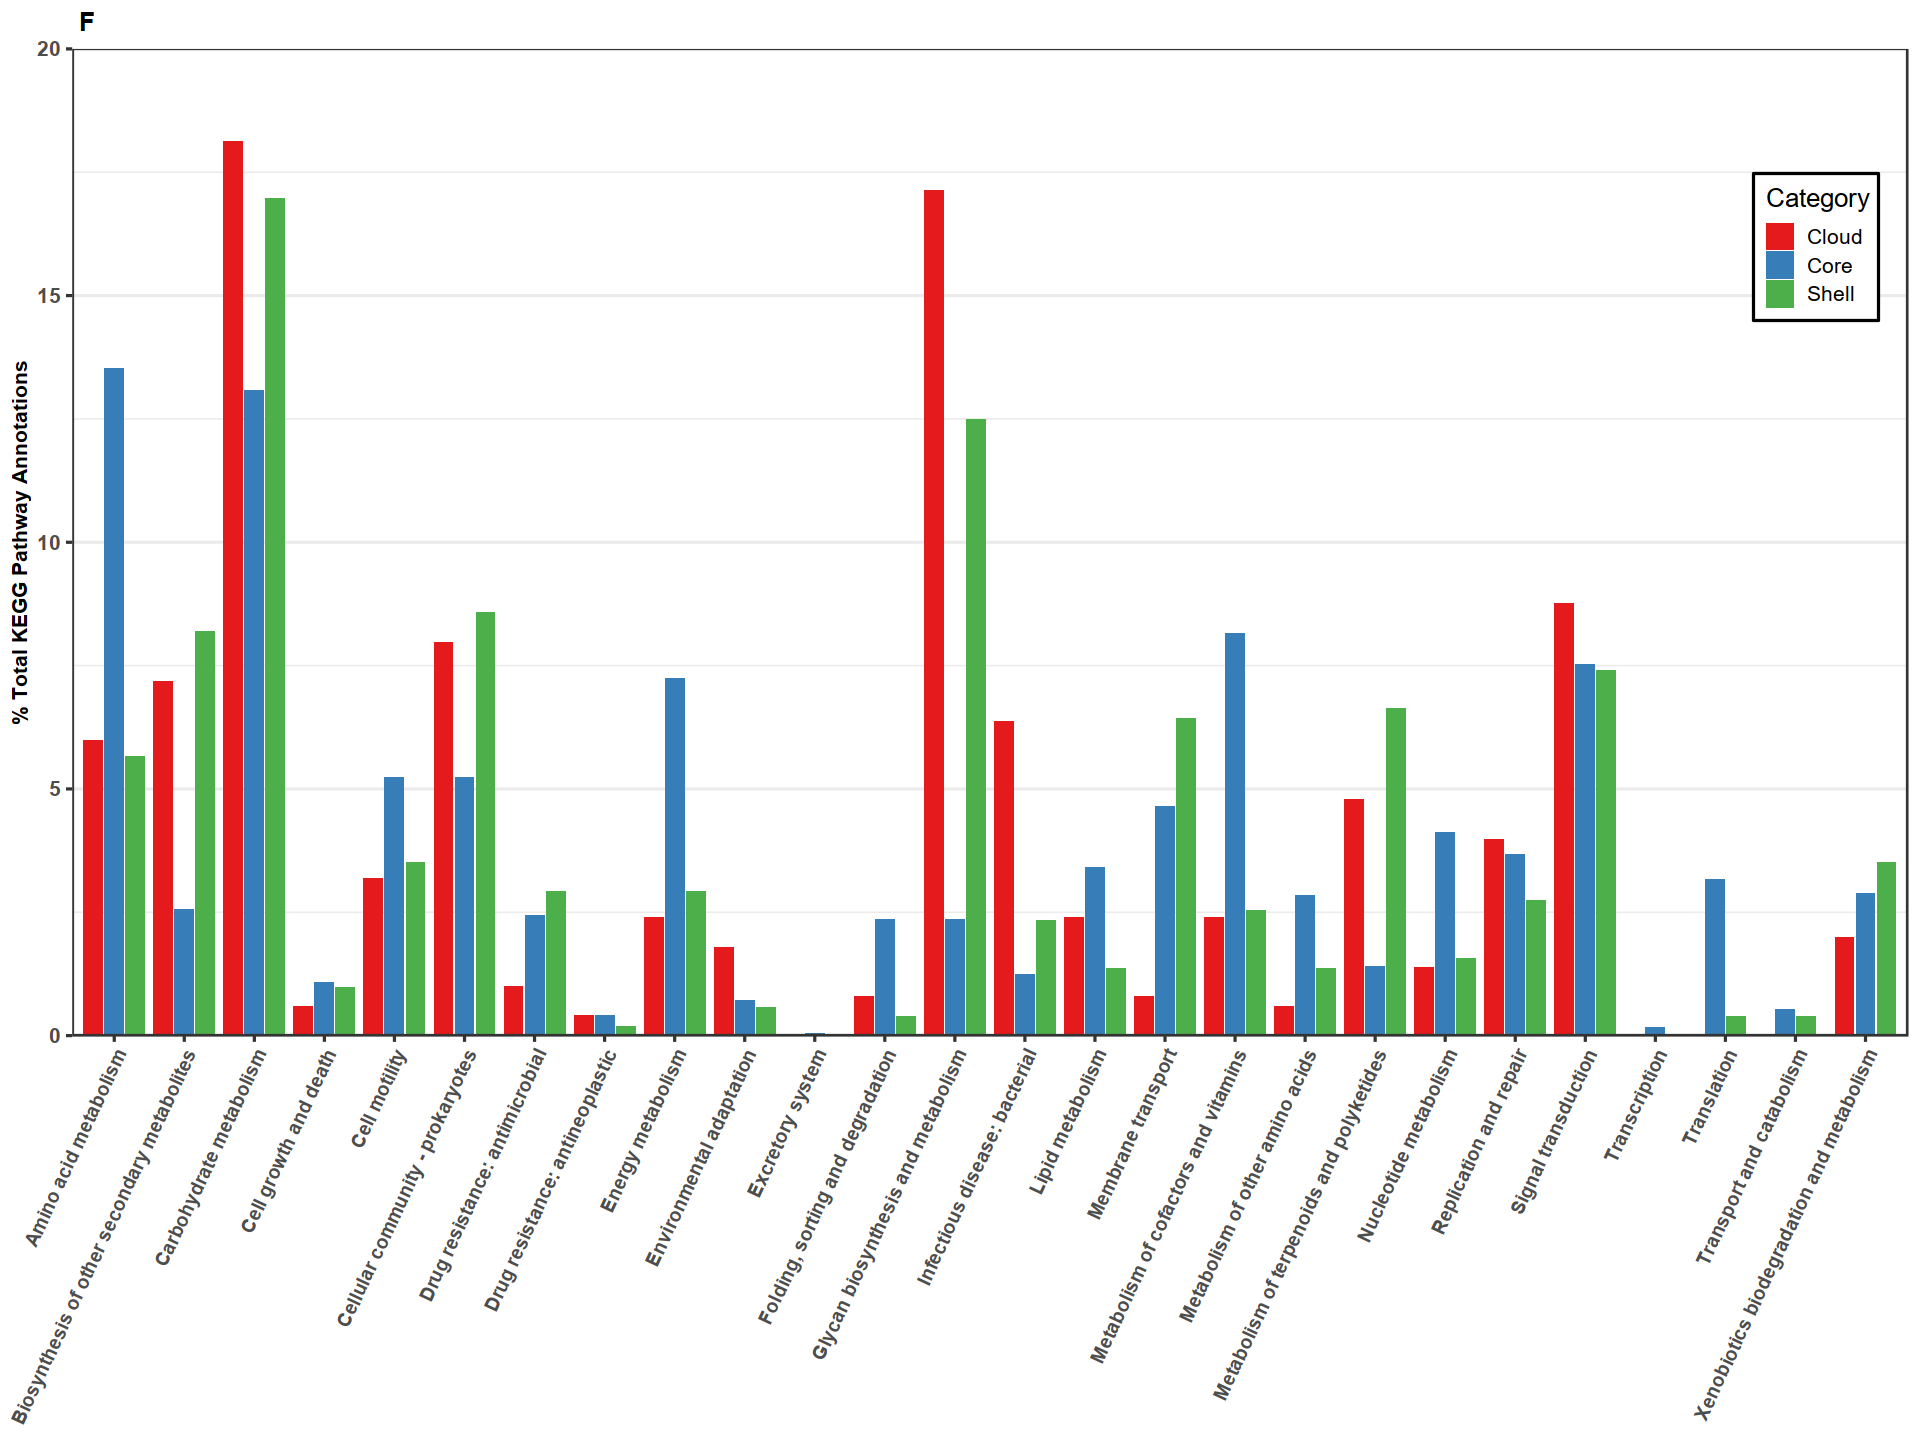

In [36]:

kegg_plot <- ggplot(pg_kegg, aes(x = L2, y = p_total, fill = Category)) +
    geom_col(position = position_dodge2(width = 0.5, preserve = "single")) +
    scale_fill_brewer(palette = "Set1") +
    scale_y_continuous(limits = c(0, 20), expand = c(0,0)) +
    theme_bw(base_size = 15) +
    labs(subtitle = " F ", y = "% Total KEGG Pathway Annotations") +
    theme(axis.title = element_text(size = 12),
          plot.subtitle = element_text(face = "bold"),
          axis.text.x = element_text(angle = 65, vjust = 1, hjust = 1, size = 11, face = "bold"),
          axis.text.y = element_text(size = 12, face = "bold"),
          axis.title.x = element_blank(),
          axis.title.y = element_text(face = "bold"),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.x = element_blank(),
          legend.position = c(0.95, 0.799),
          legend.background = element_rect(fill = "white", color = "black")
         )
kegg_plot

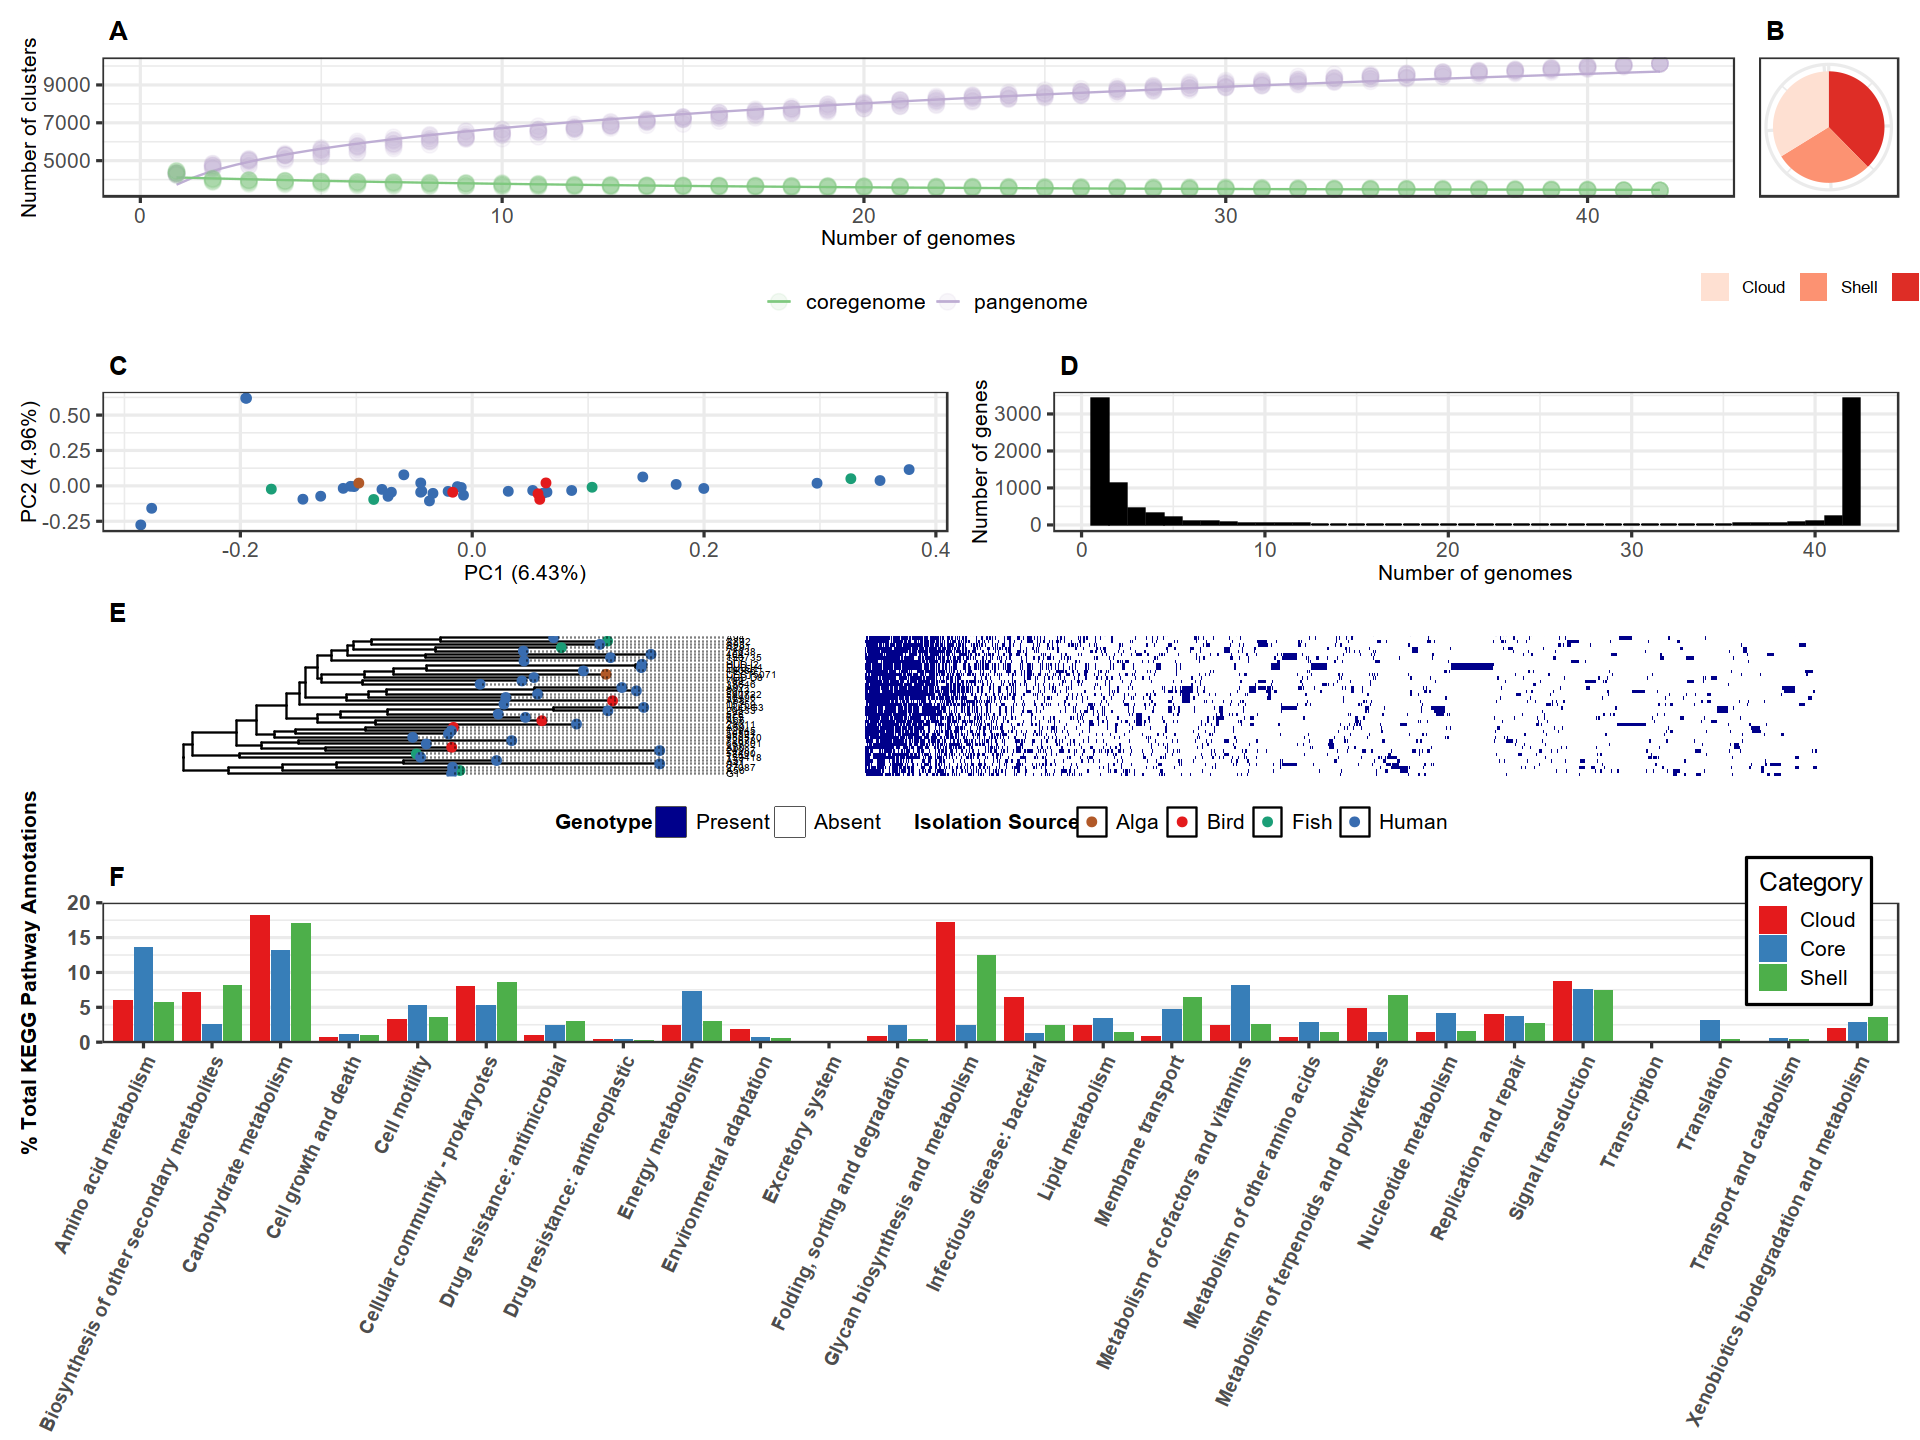

In [37]:
figplot <- grid1 / grid2 / kegg_plot

figplot

# save plot
ggsave("./r_plots/fig1.pdf", figplot, height = 50, width = 30, units = "cm", dpi = 600 )

ggsave("./r_plots/fig1.png", figplot, device = "png", height = 50, width = 30, units = "cm", dpi = 600)

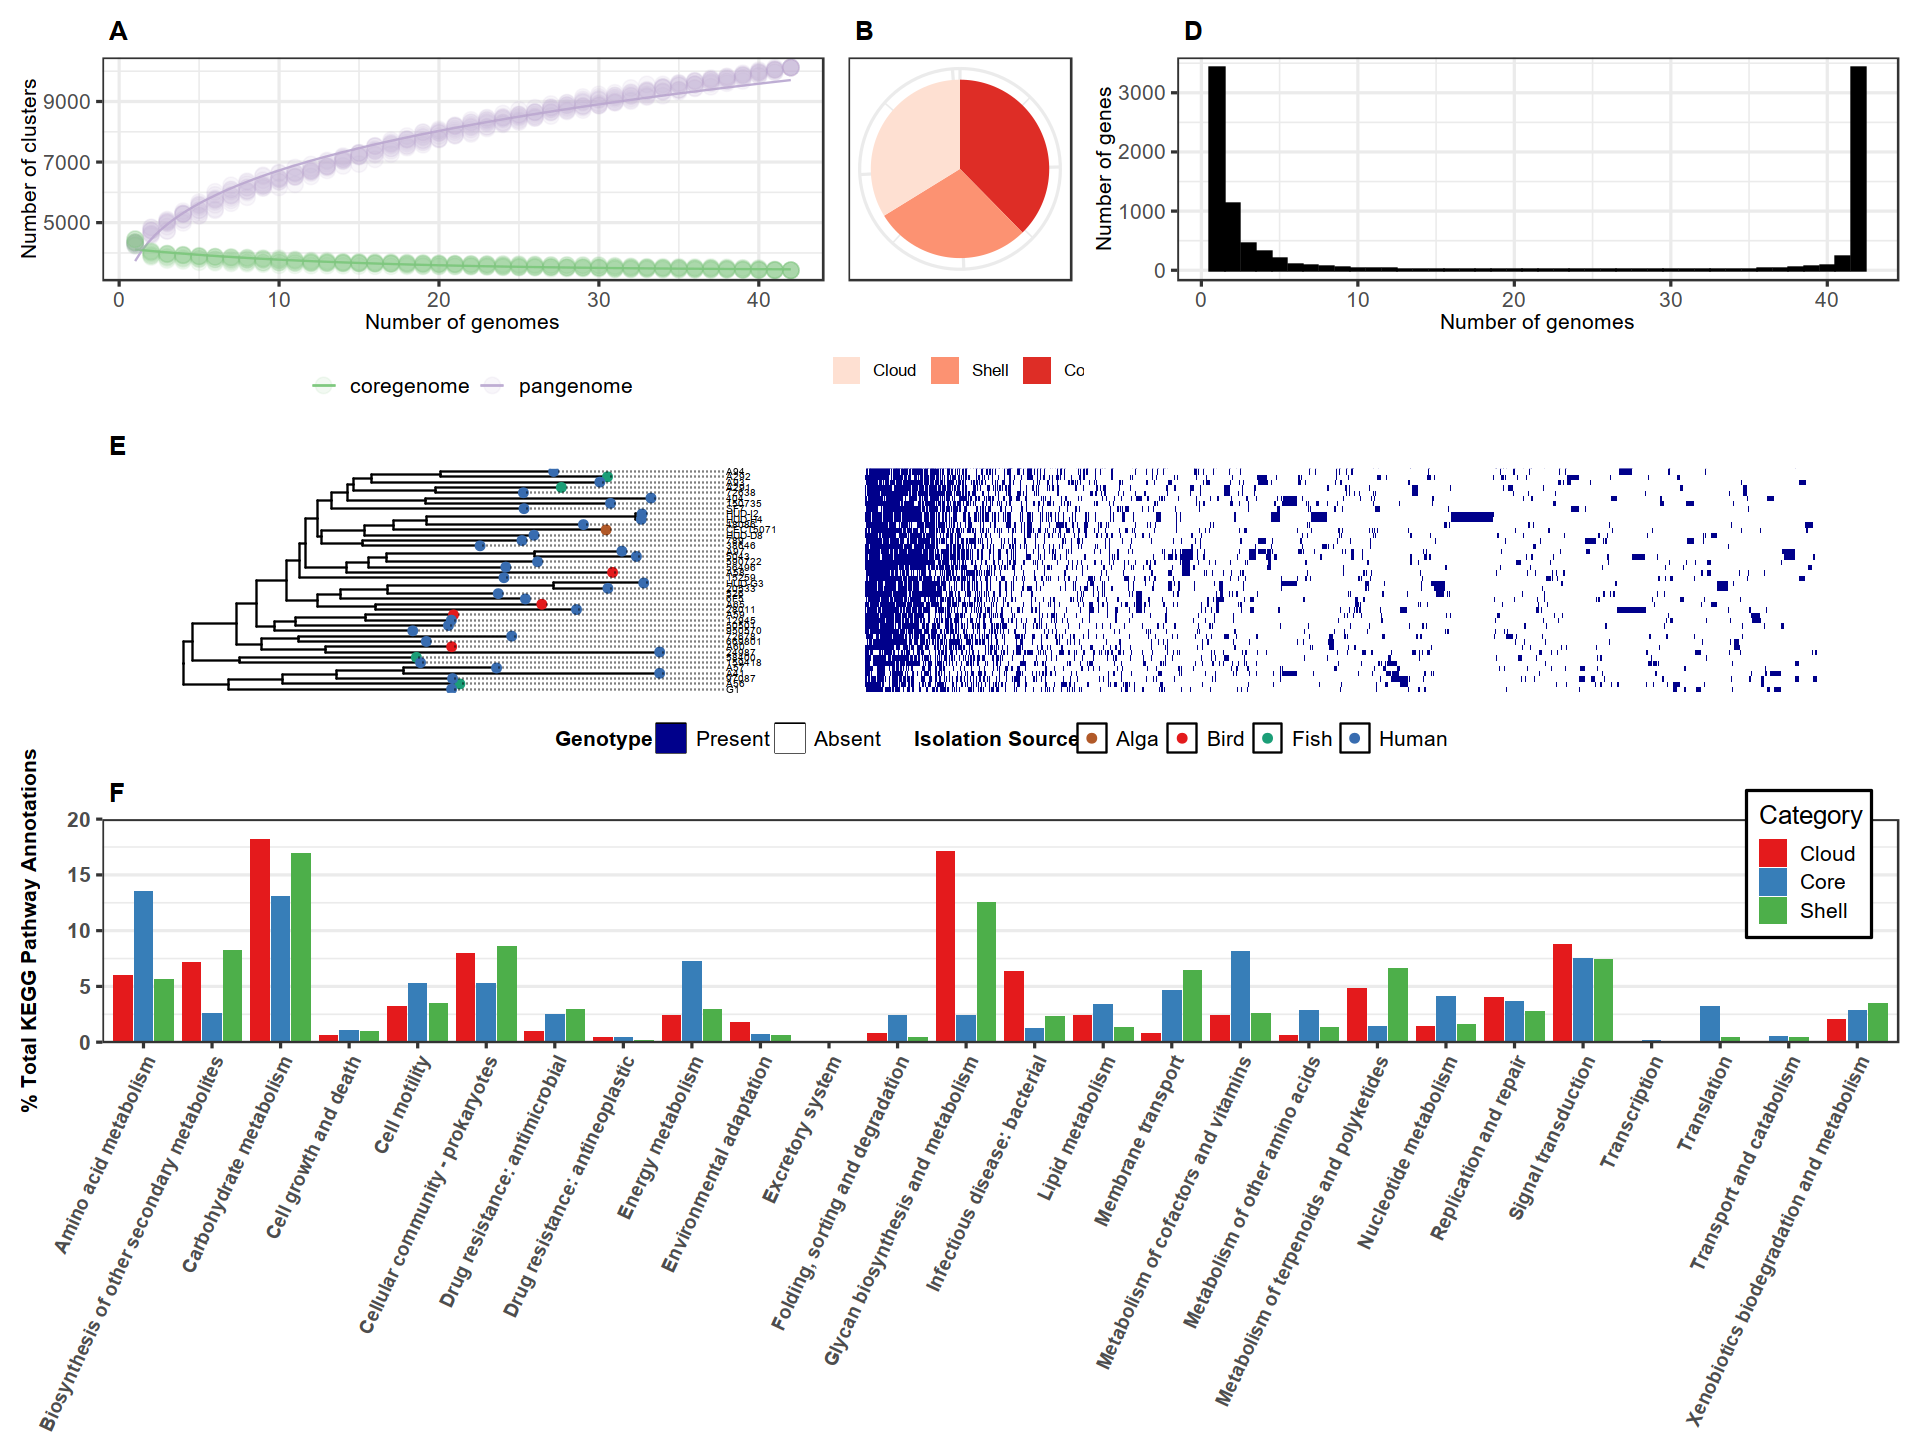

In [38]:
grid4 <- (curves + pie + bars)

figplot2 <- grid4 / grid2 / kegg_plot

figplot2

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



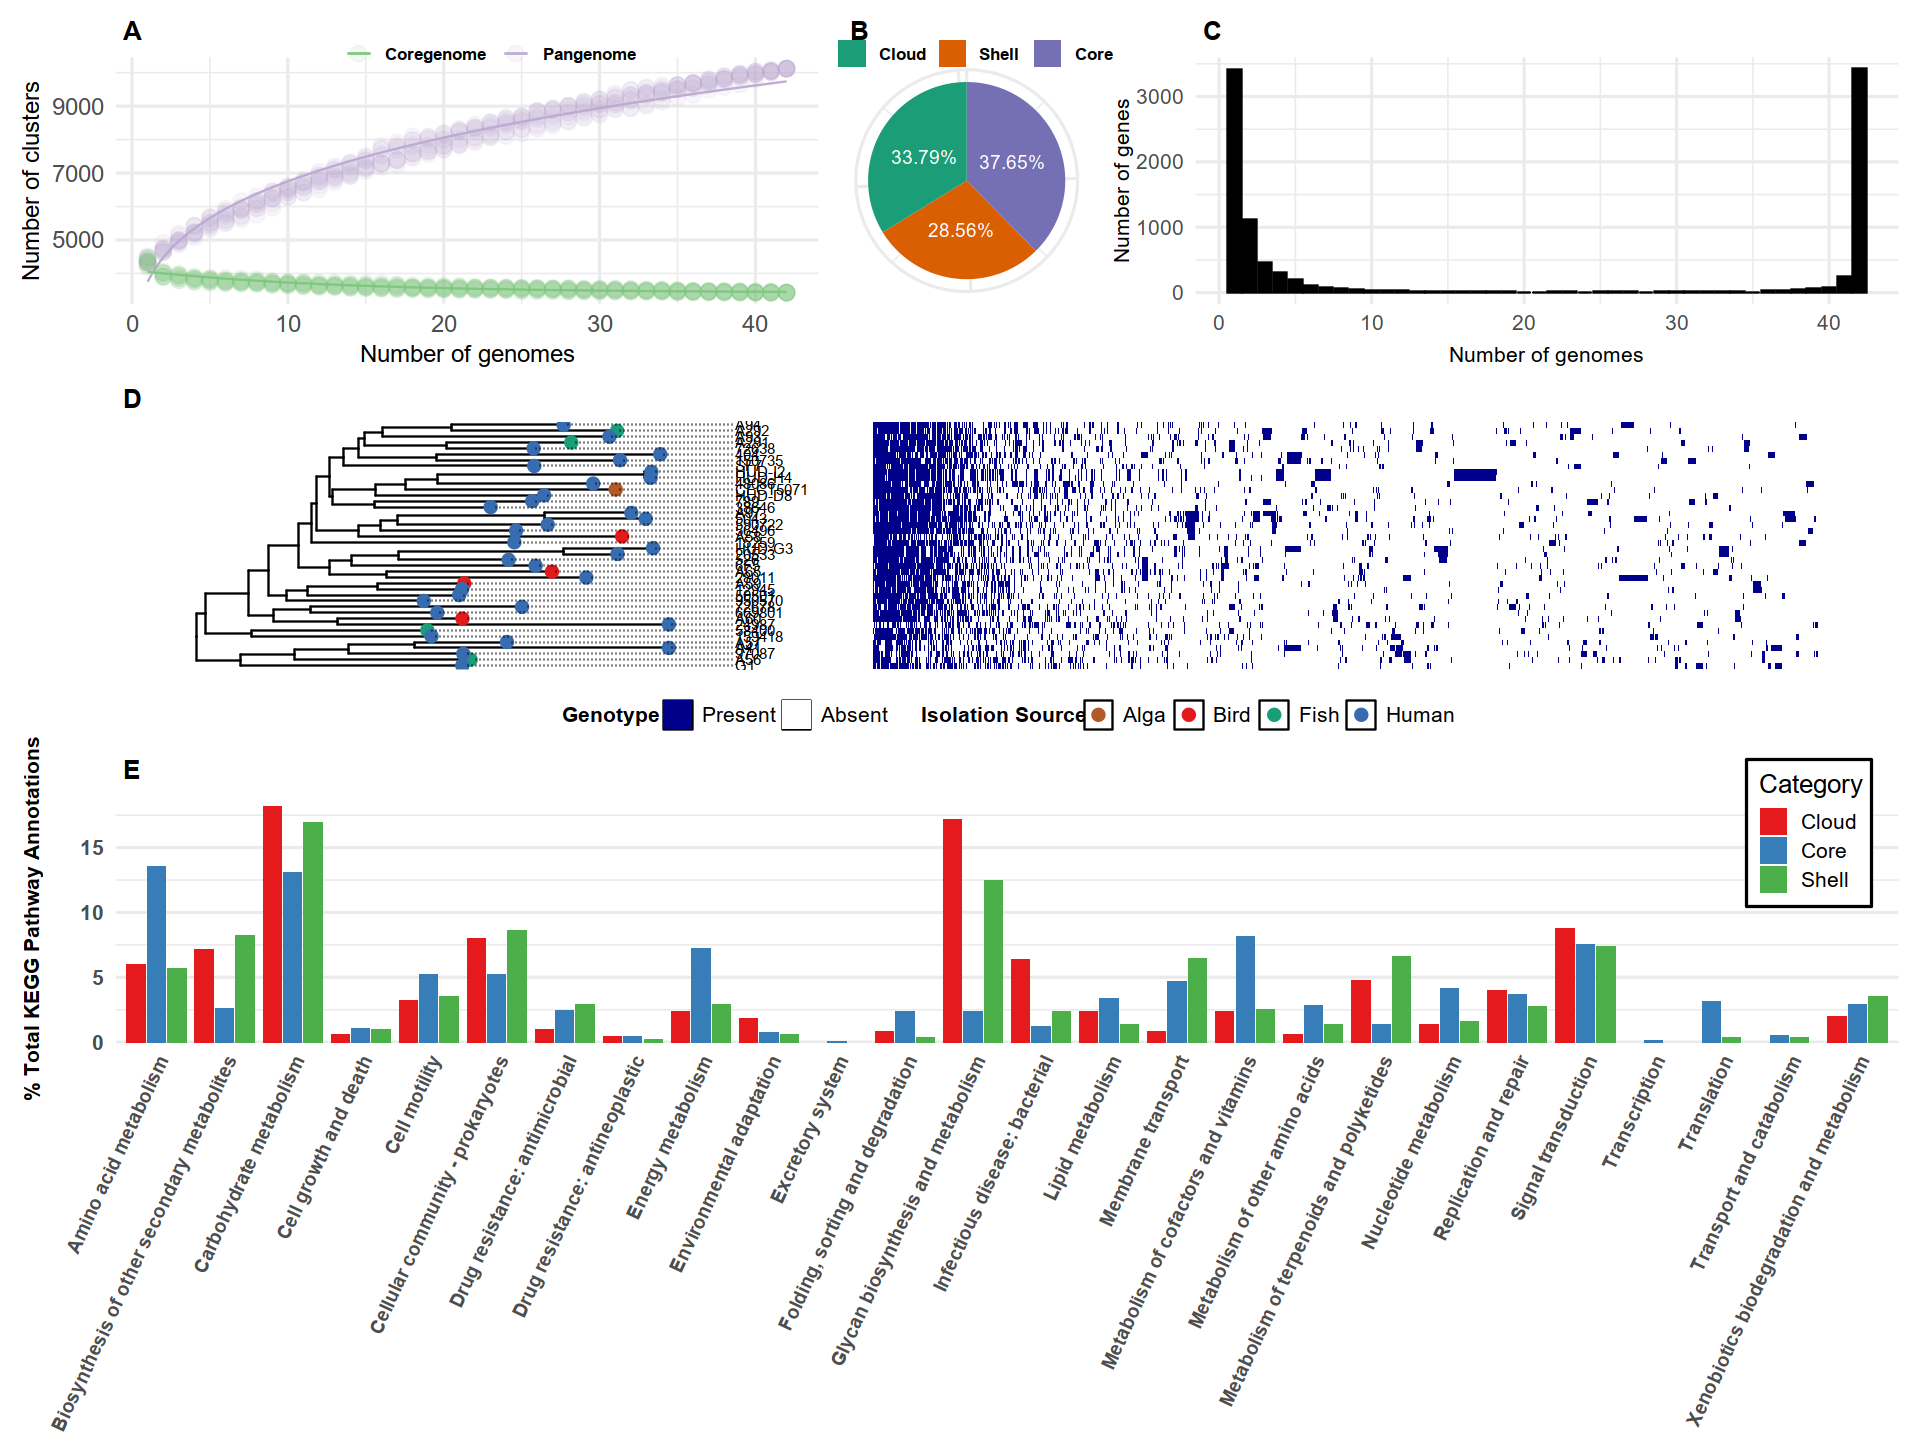

In [127]:
# 1. Pangenome curves
curves2 <- pg$gg_curves() +                                     # Plot core- and pan-genome curves
          scale_color_brewer(labels = c("Coregenome", "Pangenome"), palette = "Accent") +
          guides(color = guide_legend(nrow = 1)) +
          #scale_color_manual(values = c('black', 'black')) +  # Customize line colors
          geom_point(alpha = .1, size = 4) + #, color = 'grey') + # Add semi-transparent data points
          theme_minimal(base_size = 15) +                          # Customize background theme
          labs(subtitle = " A ") +
          theme(legend.position = c(0.535, 1.04),
          legend.margin = margin(0, 0, 0, 0),                # Change legend margins
          legend.box.margin = margin(0, 0, 0, 0),             # Change box margins
          #legend.background = element_rect(fill = "white", color = "black"),
          legend.title = element_blank(),
          legend.text = element_text(size = 10, face = "bold"),
          plot.subtitle = element_text(face = "bold"),
          axis.title = element_text(size = 14),                     # Customize axis title
          axis.text = element_text(size = 14))                      # Customize axis text size

# 2. Pie chart of core and accessory genes
pie2 <- pg$gg_pie() +                                         # Plot pie chart
  theme_minimal(base_size = 15) +                                # Customize background theme
  geom_text(aes(label = paste0(c("37.65", "28.56", "33.79"), "%")),
            position = position_stack(vjust = 0.5),
            size = 4,
            color = "white") +
  scale_fill_discrete(guide = guide_legend(keywidth = .75,
                                           keyheight = .75)) + # Customize fill
  scale_fill_brewer(palette = "Dark2") +                    # Customize fill color
  scale_x_discrete(breaks = c(0, 25, 50, 75)) +             # Customize axis scales
  guides(fill = guide_legend(nrow = 1)) +
  labs(subtitle = " B ") +
  theme(legend.position = c(0.535, 1.04),
        #legend.background = element_rect(fill = "white", color = "black"),
        legend.title = element_blank(),                     # Remove legend title
        legend.text = element_text(size = 10, face = "bold"),              # Change legend text size
        legend.box = "horizontal",
        legend.margin = margin(0, 0, 0, 0),                # Change legend margins
        legend.box.margin = margin(0, 0, 0, 0),             # Change box margins
        axis.title.x = element_blank(),                     # Remove X-axis title
        axis.title.y = element_blank(),                     # Remove Y-axis title
        axis.ticks = element_blank(),                       # Remove axis ticks
        plot.subtitle = element_text(face = "bold"),
        axis.text.x = element_blank())                      # Remove X-axis text

# 3. Gene frequency bar plots
bars2 <- pg$gg_barplot() +                                       # Plot gene frequency distribution
  theme_minimal(base_size = 15) +                                   # Customize background color
  labs(subtitle = " C ") +
  theme(axis.title = element_text(size = 12),                  # Customize axis label size
        plot.subtitle = element_text(face = "bold"),
        axis.text=element_text(size = 12)) +                   # Customize axis text size
  geom_bar(stat = 'identity', color = 'black', fill = 'black') # Customize bar color and borders

# 4. KEGG Plot
kegg_plot2 <- ggplot(pg_kegg, aes(x = L2, y = p_total, fill = Category)) +
    geom_col(position = position_dodge2(width = 0.5, preserve = "single")) +
    scale_fill_brewer(palette = "Set1") +
    scale_y_continuous(limits = c(0, 19), expand = c(0,0)) +
    theme_minimal(base_size = 15) +
    labs(subtitle = " E ", y = "% Total KEGG Pathway Annotations") +
    theme(axis.title = element_text(size = 12),
          plot.subtitle = element_text(face = "bold"),
          axis.text.x = element_text(angle = 65, vjust = 1, hjust = 1, size = 11, face = "bold"),
          axis.text.y = element_text(size = 12, face = "bold"),
          axis.title.x = element_blank(),
          axis.title.y = element_text(face = "bold"),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.x = element_blank(),
          legend.position = c(0.95, 0.85),
          legend.background = element_rect(fill = "white", color = "black")
         )

Fig2_p1 <- (curves2 + pie2 + bars2)

Fig2_p2 <- gh1 + labs(subtitle = " D ") + theme(plot.subtitle = element_text(size = 15, face = "bold"))

Fig2_p3 <- Fig2_p1 / Fig2_p2 / kegg_plot2 # + plot_layout(heights = unit(c(4, 6, 4), c('cm', 'cm', 'cm')))

Fig2_p3

# save plot
ggsave("./r_plots/fig2.pdf", Fig2_p3, device = "pdf", width = 30, height = 50, units = "cm", dpi = 600)



In [81]:
pg$summary_stats

DataFrame with 4 rows and 2 columns
     Category    Number
  <character> <integer>
1       Total     10122
2        Core      3811
3       Shell      2891
4       Cloud      3420

In [407]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 8

Matrix products: default
BLAS/LAPACK: /ceph/home/shigdon/.conda/envs/smash-jupyter/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=C.UTF-8           LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] KEGGREST_1.32.0     RColorBrewer_1.1-2  ggnewscale_0.4.5   
 [4] magrittr_2.0.1      phangorn_2.7.1      ape_5.5            
 [7] ggtree_3.0.1        patchwork_1.1.1     ggrepel_0.9.1      
[10] cowplot_1.1.1       forcats_0.5.1       stringr_1.4.0      
[13] dplyr_1.0.